**Sentiment Analysis of IMDB Movie Reviews**

**Import necessary libraries**

In [2]:
#Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import os
import warnings
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AutoModel

**Import the training dataset**

In [3]:
#importing the training data
imdb_data=pd.read_csv('dataset/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
imdb_data.drop_duplicates(inplace = True)
imdb_data.dropna(inplace = True)
imdb_data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
imdb_data.sentiment.unique()

array(['positive', 'negative'], dtype=object)

**Exploratery data analysis**

In [5]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


**Sentiment count**

In [6]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

We can see that the dataset is balanced.

**Labeling the sentiment text**

In [6]:
#labeling the sentient data
lb = LabelBinarizer()
#transformed sentiment data
imdb_data['sentiment'] = lb.fit_transform(imdb_data['sentiment']).squeeze()
imdb_data['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 49582, dtype: int32

**Preprocessing Text**

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stopword_list = nltk.corpus.stopwords.words('english')

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = [token.strip() for token in text.split()]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Removing the noisy text, stem dan stopword tidak digunakan pada preprocessing kasus bert
def preprocess_text(input_text: str, processing_function_list = None) -> str:
    """ Preprocess an input text by executing a series of preprocessing functions specified in functions list """
    if processing_function_list is None:
        processing_function_list = [
            strip_html,
            remove_between_square_brackets,
            remove_special_characters,
        ]
    for func in processing_function_list:
        input_text = func(input_text)
    if isinstance(input_text, str):
        processed_text = input_text
    else:
        processed_text = ' '.join(input_text)
    return processed_text


In [10]:
#Apply function on review column
imdb_data['preprocessed_review'] = imdb_data['review'].apply(preprocess_text)
imdb_data.to_csv('dataset/preprocessed_dataset.csv', index=False)

C:\Users\vanya\AppData\Local\Temp\ipykernel_22996\309689101.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


KeyboardInterrupt: 

In [11]:
imdb_data

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,A wonderful little production The filming tech...
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,Basically theres a family where a little boy J...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Matteis Love in the Time of Money is a ...
...,...,...,...
49995,I thought this movie did a down right good job...,1,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,Bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,0,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,0,Im going to have to disagree with the previous...


(array([3.5201e+04, 1.0580e+04, 2.6700e+03, 1.0270e+03, 8.4000e+01,
        9.0000e+00, 5.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([   4. ,  248.6,  493.2,  737.8,  982.4, 1227. , 1471.6, 1716.2,
        1960.8, 2205.4, 2450. ]),
 <BarContainer object of 10 artists>)

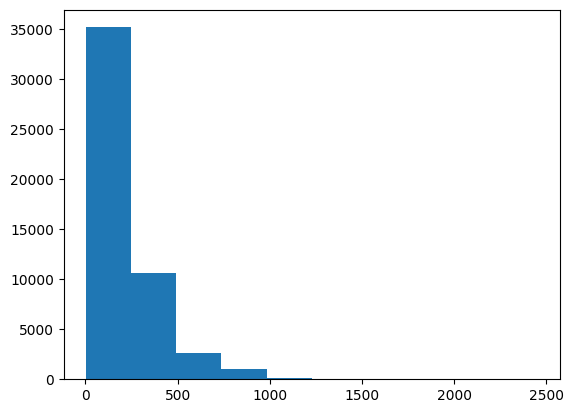

In [10]:
words = imdb_data.preprocessed_review.apply(lambda x : len(x.split()))
plt.hist(words)

**Modelling the dataset**

Let us build logistic regression model for both bag of words and tfidf features

In [12]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['preprocessed_review']
        labels = self.data.iloc[index]['sentiment'].astype(int)
        encoding = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        # resize the tensors to the same size
        input_ids = nn.functional.pad(input_ids, (0, self.max_length - input_ids.shape[0]), value=0)
        attention_mask = nn.functional.pad(attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0)
        return input_ids, attention_mask, torch.tensor(labels)

In [18]:
idx_split = 45000

imdb_data[:idx_split]

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,1,A wonderful little production The filming tech...
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,0,Basically theres a family where a little boy J...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Matteis Love in the Time of Money is a ...
...,...,...,...
45326,If you've never experienced the thing that is ...,1,If youve never experienced the thing that is Z...
45327,I have to say as being a fan of the man who cr...,0,I have to say as being a fan of the man who cr...
45328,The Wind. Easily one of the worst films ever m...,0,The Wind Easily one of the worst films ever ma...
45329,"In all honesty, if someone told me the directo...",1,In all honesty if someone told me the director...


In [33]:
model_checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = BertDataset(imdb_data[:idx_split], tokenizer)
test_dataset = BertDataset(imdb_data[idx_split:], tokenizer)

In [22]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_checkpoint)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)
            # nn.Softmax()
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state'][:, 0, :]
        x = self.classifier(x)
        return x

In [37]:
num_labels = 2
model = BertClassifier(num_labels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)

num_epochs = 2
n_total_steps = len(train_loader)

In [18]:
for epoch in range(num_epochs):

  for i, batch in enumerate (train_loader):

    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)

    attention_mask = attention_mask.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(input_ids, attention_mask)

    # print(logits, labels.long())
    loss = criterion(logits, labels.long())
    # print(logits, labels, loss)
    loss.backward()
    optimizer.step()


    if (i+1) % 100 == 0:
        print(f'epoch {epoch + 1}/ {num_epochs}, batch {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

c:\Users\vanya\nlp_kuliah\nlp_kuliah\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch 1/ 2, batch 100/1550, loss = 0.4248
epoch 1/ 2, batch 200/1550, loss = 0.4539
epoch 1/ 2, batch 300/1550, loss = 0.4518
epoch 1/ 2, batch 400/1550, loss = 0.4083
epoch 1/ 2, batch 500/1550, loss = 0.4476
epoch 1/ 2, batch 600/1550, loss = 0.3762
epoch 1/ 2, batch 700/1550, loss = 0.4051
epoch 1/ 2, batch 800/1550, loss = 0.4863
epoch 1/ 2, batch 900/1550, loss = 0.4959
epoch 1/ 2, batch 1000/1550, loss = 0.3966
epoch 1/ 2, batch 1100/1550, loss = 0.4306
epoch 1/ 2, batch 1200/1550, loss = 0.3207
epoch 1/ 2, batch 1300/1550, loss = 0.5094
epoch 1/ 2, batch 1400/1550, loss = 0.4434
epoch 1/ 2, batch 1500/1550, loss = 0.4187
epoch 2/ 2, batch 100/1550, loss = 0.4161
epoch 2/ 2, batch 200/1550, loss = 0.4098
epoch 2/ 2, batch 300/1550, loss = 0.3900
epoch 2/ 2, batch 400/1550, loss = 0.3702
epoch 2/ 2, batch 500/1550, loss = 0.4050
epoch 2/ 2, batch 600/1550, loss = 0.3275
epoch 2/ 2, batch 700/1550, loss = 0.3817
epoch 2/ 2, batch 800/1550, loss = 0.4004
epoch 2/ 2, batch 900/1550, 

In [19]:
torch.save(model.state_dict(), 'vanyacantik2.pt')

**Model performance on test data**

**Accuracy of the model**

In [20]:
# #Accuracy score for bag of words
# svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
# print("svm_bow_score :",svm_bow_score)
# #Accuracy score for tfidf features
# svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
# print("svm_tfidf_score :",svm_tfidf_score)

**Print the classification report**

In [21]:
# #Classification report for bag of words 
# lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
# print(lr_bow_report)

# #Classification report for tfidf features
# lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
# print(lr_tfidf_report)

**Confusion matrix**

In [22]:
# #confusion matrix for bag of words
# cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
# print(cm_bow)
# #confusion matrix for tfidf features
# cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
# print(cm_tfidf)

**Print the classification report**

In [23]:
# #Classification report for bag of words 
# svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
# print(svm_bow_report)
# #Classification report for tfidf features
# svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
# print(svm_tfidf_report)

**Plot the confusion matrix**

In [24]:
# #confusion matrix for bag of words
# cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
# print(cm_bow)
# #confusion matrix for tfidf features
# cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
# print(cm_tfidf)

**Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

In [25]:
# #word cloud for positive review words
# plt.figure(figsize=(10,10))
# positive_text=norm_train_reviews[1]
# WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
# positive_words=WC.generate(positive_text)
# plt.imshow(positive_words,interpolation='bilinear')
# plt.show

**Word cloud for negative review words**

In [26]:
# #Word cloud for negative review words
# plt.figure(figsize=(10,10))
# negative_text=norm_train_reviews[8]
# WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
# negative_words=WC.generate(negative_text)
# plt.imshow(negative_words,interpolation='bilinear')
# plt.show

**Conclusion:**
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines.
* Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.